# Direct multi-step forecasting

El método direct multi-step forecasting consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras.

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelos. Todo este proceso está automatizado en la clase ForecasterAutoregMultiOutput de la librería skforecast. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos.

![Proceso multipasos](diagram_skforecast_multioutput.png)

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

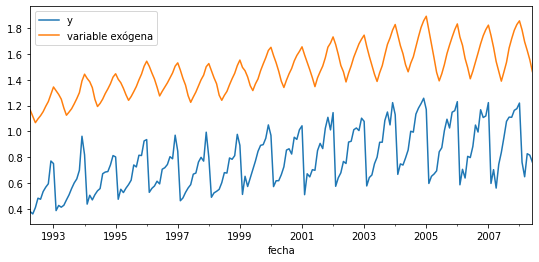

In [2]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(9, 4))
datos['y'].plot(ax=ax, label='y')
datos['exog_2'].plot(ax=ax, label='variable exógena')
ax.legend()

In [3]:
datos

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


In [4]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_train.shape, datos_test.shape

((159, 3), (36, 3))

In [7]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 8
                )

forecaster_rf.fit(y=datos_train['y'], exog=datos_train['exog_1'])

In [8]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps, exog=datos_test['exog_1'])
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

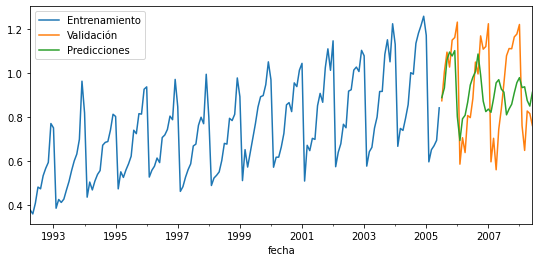

In [9]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='Entrenamiento')
datos_test['y'].plot(ax=ax, label='Validación')
predicciones.plot(ax=ax, label='Predicciones')
ax.legend()

In [10]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.03989087922533575


In [11]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train['y'],
                        exog        = datos_train['exog_1'],
                        param_grid  = param_grid,
                        lags_grid = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-09-29 15:20:47,264 root       INFO  Number of models compared: 27
loop lags_grid: 100%|████████████████████████████████████████████████████████████████████| 3/3 [01:07<00:00, 22.54s/it]
2021-09-29 15:21:54,919 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
params: {'max_depth': 3, 'n_estimators': 50}



In [11]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",0.007815,3,50
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 50}",0.007940,5,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.007944,3,500
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.008057,3,100
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.008106,10,100


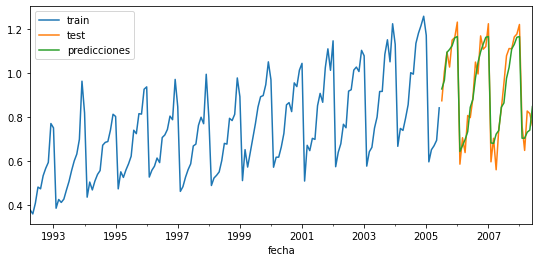

In [12]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps, exog=datos_test['exog_1'])
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

In [13]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.003965444559763559
